 # Modeling Notebook pt. 2
 This is a new notebook to work on modeling the data with neural nets,
 reflecting the specific loss function used by the Databowl challenge. Databowl
 uses a Cumulative Ranked Probability Score (CRPS) to evaluate models, which is
 given by:

 $$
 C = \frac{1}{199N} \sum^N_{m=1} \sum^{99}_{n=-99} (P(y \leq n) - H(n-Y_m))^2
 $$

 where $N$ is the number of samples, $P$ is the predicted probability
 distribution function being evaluated, $Y_m$ is the true number of yards the
 ball was carried on play $m$, and $H$ is the Heaviside step function which is
 0 for negative inputs and 1 for positive inputs.

 What does this evaluate? CRPS is the mean squared difference between two
 cumulative probability distributions: $P$ and $H$. Therefore, we can generate
 the target distribution and then just use MSE as our loss function on a
 regression with 199 outputs. This is a little rough, but the model performs
 relatively well.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
#import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split

np.set_printoptions(1)
yardrange = np.arange(-99,100)


 Feature engineering has already been done in another notebook, so all we need
 do is import the csv file we created. We index on both game id and play id, so
 we set both of those as the index.

In [2]:
data = pd.read_csv("data/fe_plays_data.csv", index_col=[0,1])
data.dropna(inplace=True)
data.head()


Unnamed: 0   Team       X      Y     S     A   Dis  \
GameId     PlayId                                                               
2017090700 20170907000118          18   True   41.25  30.53  3.63  3.35  0.38   
           20170907000139          40   True   48.93  27.16  3.06  2.41  0.34   
           20170907000189          62   True   71.34  19.11  5.77  2.42  0.60   
           20170907000345          84   True  104.47  25.36  4.45  3.20  0.46   
           20170907000395          98  False   29.99  27.12  3.90  2.53  0.44   

                           Orientation     Dir  Season  ...  Formation_PISTOL  \
GameId     PlayId                                       ...                     
2017090700 20170907000118       198.02  114.26    2017  ...                 0   
           20170907000139       149.30   47.80    2017  ...                 0   
           20170907000189       219.18  138.04    2017  ...                 0   
           20170907000345       173.78   84.56    2017  ...                 0   
           20170907000395        34.27  157.92    2017  ...                 0   

                           Formation_SHOTGUN  Formation_SINGLEBACK  \
GameId     PlayId                                                    
2017090700 20170907000118                  1                     0   
           20170907000139                  1                     0   
           20170907000189                  0                     1   
           20170907000345                  0                     0   
           20170907000395                  1                     0   

                           Formation_WILDCAT  PlayerBMI  TimeDelta  PlayerAge  \
GameId     PlayId                                                               
2017090700 20170907000118                  0  29.411224        1.0  25.596251   
           20170907000139                  0  29.411224        1.0  25.596252   
           20170907000189                  0  29.411224        2.0  25.596253   
           20170907000345                  0  29.285856        2.0  26.852933   
           20170907000395                  0  30.122595        1.0  22.091819   

                           YardsLeft  YardLine_adj  X_adj  
GameId     PlayId                                          
2017090700 20170907000118         35            35  -3.75  
           20170907000139         43            43  -4.07  
           20170907000189         65            65  -3.66  
           20170907000345         98            98  -3.53  
           20170907000395         25            25  -5.01  

[5 rows x 41 columns]

 We have to normalize all the data around its mean in order for the neural
 network to train effectively.

 We define `cdf` to generate the "true" matrix that we will compare against in
 the predicted matrix. We convert all the target values (integer numbers of
 yards) into cumulative probability distributions with the method described by
 the CRPS implementation in the Databowl evaluation page.

 This model is trained to predict the pdf (probability density function)
 instead of the cdf (cumulative density function). This is because the rules
 stipulathat the cdf prediction must be *non-decreasing*. It's much easier to
 prevent negative outputs from o ur model, so predicting the pdf resolves this
 issue.

In [3]:
data = data.astype(np.float32)
target = data.pop("Yards").astype(np.int)
stats = data.describe().transpose()


In [4]:
def norm(x):
    return (x - stats['mean']) / stats['std']

norm_data = norm(data).astype(np.float32)

def cdf(n):
    return [0]*(99+n) + [1]*(100-n)

def pdf(n):
    arr = [0] * 199
    arr[n+99] = 1
    return arr


 We apply the pdf function to turn the numeric Yards feature into probability
 distributions, then use sklearn to split the dataset.

In [5]:
x = norm_data.values
y = np.array(list(target.map(pdf)), dtype=np.float32)
x_train, x_test, y_train, y_test = train_test_split(x, y)


 This distribution-based model (with CRPS loss) is a bit harder to interpret,
 so we establish a baseline to evaluate against. We build this baseline by
 creating a pdf from the mean distribution of the target variable (yards gained
 on the play) and calculating its mean squared error against the data.

Baseline MSE: 0.0132


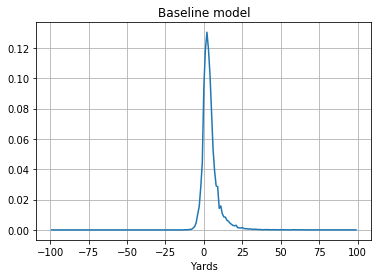

In [6]:
baseline = y.mean(axis=0)
y_pred_cdf = np.cumsum(baseline)
y_true_cdf = np.cumsum(y, axis=1)

baseline_mse = np.mean(np.square(y_true_cdf - y_pred_cdf))
print(f"Baseline MSE: {baseline_mse:.4f}")

plt.plot(yardrange, baseline)
plt.title("Baseline model")
plt.xlabel("Yards")
plt.grid()
plt.show()


 ## Train Model
 This is a relatively simple feed-forward neural network regression that
 produces 199 outputs. Because the CRPS metric is essentially
 mean-squared-error on a probability distribution, we create the `pdf_CRPS`
 function which converts the PDFs into CDFs and wraps
 `tf.keras.losses.MeanSquaredError` to calculate our loss.

 I would also at some point like to introduce K-fold cross validation in order
 evaluate the performance of the model more effectively.

In [7]:
def compile_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(x.shape[1], name='input'),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(199, activation='softmax')
    ])
    
    mse = tf.keras.losses.MeanSquaredError()
    def pdf_CRPS(y_true_pdf, y_pred_pdf):
        """ 
        Calculates CRPS from two PDFs by taking their cumulative sums and
        computing their mean squared error.
        """
        y_true_cdf = tf.math.cumsum(y_true_pdf,axis=1)
        y_pred_cdf = tf.math.cumsum(y_pred_pdf,axis=1)

        return mse(y_true_cdf, y_pred_cdf)

    model.compile(optimizer='adam', loss=pdf_CRPS)
    return model

EPOCHS = 50
stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model = compile_model()
history = model.fit(x_train,y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    callbacks=[stop],
    verbose=0
)


 ## Model training performance
 We compare the training performance of the net against three pre-determined
 values:

 - `baseline_mse`: the baseline calculated earlier
 - `goal_mse`: the CRPS score of the 50th ranked Kaggle submission
 - `best_mse`: the CRPS score of the 1st ranked Kaggle submission

 We generate two plots: one which shows the entire training history, and one
 which focuses on the final few epochs to see how our model training finishes.

loss  val_loss
45  0.011923  0.012747
46  0.011934  0.012886
47  0.011907  0.012822
48  0.011888  0.012818
49  0.011889  0.013048


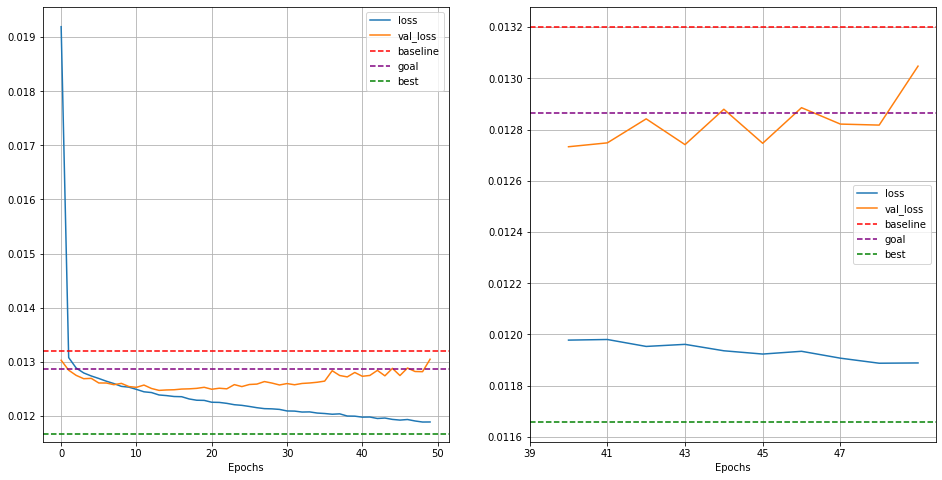

In [8]:
hist = pd.DataFrame(history.history)
fig, axes = plt.subplots(1,2, figsize=(16,8))
goal_mse = 0.012864
best_mse = 0.011658

for start,ax in zip([0,-10], axes):
    ax.plot(hist.loss[start:], label='loss')
    ax.plot(hist.val_loss[start:], label='val_loss')

    ax.axhline(baseline_mse, label='baseline', c='red', ls='--')
    ax.axhline(goal_mse, label='goal', c='purple', ls='--')
    ax.axhline(best_mse, label='best', c='green', ls='--')
    
    ax.legend()
    ax.grid()

    ax.set_xlabel("Epochs")

axes[1].set_xticks(np.arange(start % hist.index.max(), hist.index.max(), 2))

print(hist.tail(5))
fig.show()


 It's clear that the model is overfitting toward the end of its training--we
 may be able to improve this performance with cross-validation.

 ## Model Evaluation
 Our primary concern is preventing overfitting, as we have many features and
 not a lot of significant information.

 We can examine the model's performance with a case study, comparing the
 model's prediction of a long, 99 yard run play to a relatively normal short
 play, to see if the predictions differ noticeably

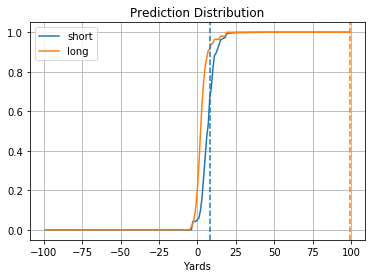

In [12]:
y_pred_short = np.cumsum(model.predict(x[:1])[0], axis=0)
y_pred_long = np.cumsum(model.predict(x[20127:20128])[0], axis=0)

plt.plot(yardrange, y_pred_short, color='tab:blue', label='short')
plt.plot(yardrange, y_pred_long, color='tab:orange', label='long')

plt.axvline(target[0], color='tab:blue', linestyle='--')
plt.axvline(target[20127], color='tab:orange', linestyle='--')

plt.title("Prediction Distribution")
plt.xlabel("Yards")
plt.grid()
plt.legend()

plt.show()


 The fact that the predictions for these two plays differ significantly shows
 that our model has some predictive power. Finally, we can check the model's
 performance on the test set that we built earlier.

In [15]:
score = model.evaluate(x_test, y_test)
print(f"Test CRPS: {score:.4f}")


7676/7676 [==============================] - 1s 90us/sample - loss: 0.0128
Test CRPS: 0.0128
